<a href="https://colab.research.google.com/github/eulerianKnight/ExplainableAI/blob/main/UCI_credit_default_XAI_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet --upgrade eli5 pdpbox interpret dice_ml xlrd

     |████████████████████████████████| 216 kB 27.0 MB/s 
     |████████████████████████████████| 34.0 MB 204 kB/s 
     |████████████████████████████████| 213 kB 63.6 MB/s 
     |████████████████████████████████| 96 kB 4.9 MB/s 
     |████████████████████████████████| 133 kB 63.5 MB/s 
     |████████████████████████████████| 13.1 MB 40.6 MB/s 
     |████████████████████████████████| 6.6 MB 18.1 MB/s 
     |████████████████████████████████| 3.6 MB 28.6 MB/s 
     |████████████████████████████████| 5.8 MB 31.7 MB/s 
     |████████████████████████████████| 9.8 MB 36.7 MB/s 
     |████████████████████████████████| 569 kB 63.4 MB/s 
     |████████████████████████████████| 275 kB 54.8 MB/s 
     |████████████████████████████████| 132 kB 48.1 MB/s 
     |████████████████████████████████| 793 kB 45.5 MB/s 
     |████████████████████████████████| 756 kB 50.9 MB/s 
     |████████████████████████████████| 281 kB 70.3 MB/s 
     |████████████████████████████████| 95 kB 4.4 MB/s 
     |███████████

In [ ]:
# Download UCI Credit default dataset
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'

--2022-08-01 09:00:14--  https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5539328 (5.3M) [application/x-httpd-php]
Saving to: ‘default of credit card clients.xls’

default of credit c 100%[===================>]   5.28M  9.23MB/s    in 0.6s    

2022-08-01 09:00:15 (9.23 MB/s) - ‘default of credit card clients.xls’ saved [5539328/5539328]



In [ ]:
# Import required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

from interpret.glassbox import (LogisticRegression, 
                                ClassificationTree, 
                                ExplainableBoostingClassifier)
from interpret.blackbox import LimeTabular
from interpret import show

import shap

import dice_ml

In [ ]:
# Read file as pandas dataframe
data = pd.read_excel('/content/default of credit card clients.xls', 
                     header=1, 
                     index_col=0)
data.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
ID                                                                         
1       20000    2          2         1   24      2      2     -1     -1   
2      120000    2          2         2   26     -1      2      0      0   
3       90000    2          2         2   34      0      0      0      0   
4       50000    2          2         1   37      0      0      0      0   
5       50000    1          2         1   57     -1      0     -1      0   

    PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
ID         ...                                                                  
1      -2  ...          0          0          0         0       689         0   
2       0  ...       3272       3455       3261         0      1000      1000   
3       0  ...      14331      14948      15549      1518      1500      1000   
4       0  ...      28314      28959      29547      2000      2019      1200   
5       0  ...      20940      19146      19131      2000     36681     10000   

    PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
ID                                                            
1          0         0         0                           1  
2       1000         0      2000                           1  
3       1000      1000      5000                           0  
4       1100      1069      1000                           0  
5       9000       689       679                           0  

[5 rows x 24 columns]

In [ ]:
# print basic info
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

In [ ]:
# One hot encoding Categorical columns
categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE'] 
for col in categorical_cols:
    col_ohe = pd.get_dummies(data[col], prefix=col)
    data = pd.concat((data, col_ohe), axis=1).drop(col, axis=1)

In [ ]:
data.head()

LIMIT_BAL  AGE  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  \
ID                                                                        
1       20000   24      2      2     -1     -1     -2     -2       3913   
2      120000   26     -1      2      0      0      0      2       2682   
3       90000   34      0      0      0      0      0      0      29239   
4       50000   37      0      0      0      0      0      0      46990   
5       50000   57     -1      0     -1      0      0      0       8617   

    BILL_AMT2  ...  EDUCATION_1  EDUCATION_2  EDUCATION_3  EDUCATION_4  \
ID             ...                                                       
1        3102  ...            0            1            0            0   
2        1725  ...            0            1            0            0   
3       14027  ...            0            1            0            0   
4       48233  ...            0            1            0            0   
5        5670  ...            0            1            0            0   

    EDUCATION_5  EDUCATION_6  MARRIAGE_0  MARRIAGE_1  MARRIAGE_2  MARRIAGE_3  
ID                                                                            
1             0            0           0           1           0           0  
2             0            0           0           0           1           0  
3             0            0           0           0           1           0  
4             0            0           0           1           0           0  
5             0            0           0           1           0           0  

[5 rows x 34 columns]

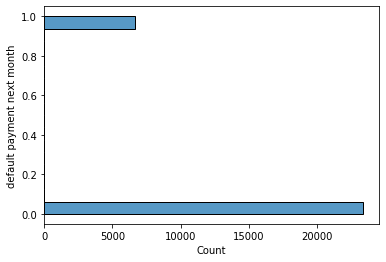

In [ ]:
# Check class balanace
sns.histplot(data, y = 'default payment next month')
plt.show()

In [ ]:
# Assign Dependent and independent variable
X = data.drop('default payment next month', axis=1)
y = data['default payment next month']

In [ ]:
# Split train test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1, 
                                                    random_state=31415926)
len(X_train), len(X_test)

(27000, 3000)

In [ ]:
# Handle Class imbalance
oversample = RandomOverSampler(sampling_strategy='minority')
x_np = X_train.to_numpy()
y_np = y_train.to_numpy()
x_np, y_np = oversample.fit_resample(x_np, y_np)
X_train = pd.DataFrame(x_np, columns=X_train.columns)
y_train = pd.Series(y_np, name=y_train.name)

In [ ]:
# # Normalize
# # Instantiate StandardScaler
# scaler = StandardScaler()
# # Fit it to the train data
# scaler.fit(X_train)
# # Use it to transform the train and test data
# X_train = scaler.transform(X_train)
# # Notice that the scaler is trained on the train data to avoid data leakage from the test set
# X_valid = scaler.transform(X_valid)

In [ ]:
# Fit a Logistic Regression Model
lr = LogisticRegression(feature_names=X_train.columns,
                        penalty='l1', 
                        solver='liblinear', 
                        random_state=31415926)
lr.fit(X_train, y_train)

In [ ]:
# Evaluate
y_pred = lr.predict(X_test)
print(f"Macro F1-Score: {f1_score(y_test, y_pred)}")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")

Macro F1-Score: 0.4924568965517242
Accuracy Score: 0.686


In [ ]:
# Explain Local prediction
lr_local = lr.explain_local(X_test[:100], y_test[:100], name='Logistic Regression')
show(lr_local)

Cloud environment detected (['colab', 'ipython']): viz integration is still experimental.


In [ ]:
# Show Global Explanation
lr_global = lr.explain_global(name='Logistic Regression')
show(lr_global)

In [ ]:
# Fit a Decision Tree classifier
tree = ClassificationTree()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")

F1 Score 0.6836959606247839
Accuracy 0.7536666666666667


In [ ]:
# Explain local prediction
tree_local = tree.explain_local(X_test[:100], y_test[:100], name='Tree')
show(tree_local)

In [ ]:
# Fit Explainable Boosting Machine
ebm = ExplainableBoostingClassifier(random_state=31415926)
ebm.fit(X_train, y_train) 
print("Training finished.")
y_pred = ebm.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")

Training finished.
F1 Score 0.6784237573758025
Accuracy 0.7466666666666667


In [ ]:
# %% Explain locally
ebm_local = ebm.explain_local(X_test[:100], y_test[:100], name='EBM')
show(ebm_local)

In [ ]:
# %% Explain globally
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

In [ ]:
# Fit a Black Box Model using Random Forest Classifier
# Fit the classifier
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(f"F1-score: {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")

F1-score: 0.6977390990854438
Accuracy 0.8103333333333333


In [ ]:
# Initilize Lime for Tabular data
lime = LimeTabular(predict_fn=rf_clf.predict_proba, 
                   data=X_train.values, 
                   random_state=31415926)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



In [ ]:
# Get local explanations
lime_local = lime.explain_local(X_test[-20:], 
                                y_test[-20:], 
                                name='LIME')

show(lime_local)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with f

In [ ]:
# Create SHAP explainer
explainer = shap.TreeExplainer(rf_clf)
# Calculate shapley values for test data
start_index = 1
end_index = 2
shap_values = explainer.shap_values(X_test[start_index:end_index])
X_test[start_index:end_index]
print(shap_values[0].shape)
shap_values

(1, 33)


[array([[ 5.64838866e-02,  9.95893744e-03,  5.75737978e-02,
          2.41752050e-02,  1.85293253e-02,  1.15095629e-02,
          8.69286502e-03,  1.18453414e-02,  2.93387560e-02,
          1.74917824e-02,  1.39408615e-02,  1.21433381e-02,
          1.69751307e-02,  6.93077284e-03,  4.01863332e-02,
          5.57402269e-02,  3.30732624e-02,  3.20534065e-02,
          1.28742090e-02,  1.86033630e-02,  5.32914805e-03,
          2.03813271e-03, -2.49284066e-06,  3.18210855e-03,
          2.03811315e-03,  1.30081346e-03,  2.28937390e-05,
         -2.55073317e-05,  2.91304625e-04, -1.09563633e-05,
         -1.32793176e-03, -1.31887107e-03,  3.28689844e-04]]),
 array([[-5.64838866e-02, -9.95893744e-03, -5.75737978e-02,
         -2.41752050e-02, -1.85293253e-02, -1.15095629e-02,
         -8.69286502e-03, -1.18453414e-02, -2.93387560e-02,
         -1.74917824e-02, -1.39408615e-02, -1.21433381e-02,
         -1.69751307e-02, -6.93077284e-03, -4.01863332e-02,
         -5.57402269e-02, -3.30732624

In [ ]:
# Visualize local predictions
shap.initjs()
# Force plot
prediction = rf_clf.predict(X_test[start_index:end_index])[0]
print(f"The RF predicted: {prediction}")
shap.force_plot(explainer.expected_value[1],
                shap_values[1],
                X_test[start_index:end_index])

The RF predicted: 0


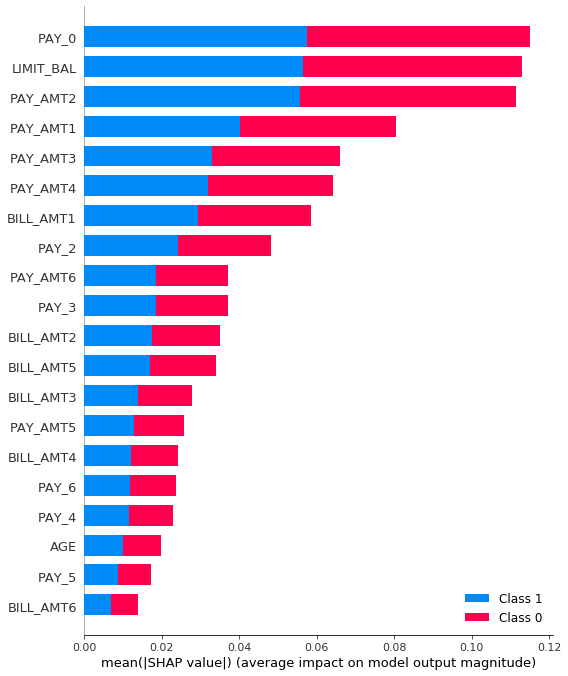

In [ ]:
# Visualize global features
# Feature summary
shap.summary_plot(shap_values, X_test)

## Counterfactual Explanations

- A Counterfactual is samllest change in input features, that changes the prediction to another (Predefined) output.

In [ ]:
data.columns

Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month',
       'SEX_1', 'SEX_2', 'EDUCATION_0', 'EDUCATION_1', 'EDUCATION_2',
       'EDUCATION_3', 'EDUCATION_4', 'EDUCATION_5', 'EDUCATION_6',
       'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3'],
      dtype='object')

In [ ]:
# Dataset
data_dice = dice_ml.Data(dataframe=data, 
                         # For perturbation strategy
                         continuous_features=['PAY_0', 
                                              'LIMIT_BAL',
                                              'PAY_AMT2',], 
                         outcome_name='default payment next month')

In [ ]:
# Model
rf_dice = dice_ml.Model(model=rf_clf,
                        backend="sklearn")
explainer = dice_ml.Dice(data_dice, 
                         rf_dice,
                         method="random")

In [ ]:
# Generate CF based on the blackbox model
input_datapoint = X_test[0:1]
cf = explainer.generate_counterfactuals(input_datapoint, 
                                  total_CFs=4, 
                                  desired_class="opposite")

100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


In [ ]:
# Visualize it
cf.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


LIMIT_BAL AGE  PAY_0 PAY_2 PAY_3 PAY_4 PAY_5 PAY_6 BILL_AMT1 BILL_AMT2  \
0     210000  30     -1    -1    -1    -1     0     0      4830         0   

   ... EDUCATION_2 EDUCATION_3 EDUCATION_4 EDUCATION_5 EDUCATION_6  \
0  ...           0           0           0           0           0   

   MARRIAGE_0 MARRIAGE_1 MARRIAGE_2 MARRIAGE_3 default payment next month  
0           0          0          1          0                          0  

[1 rows x 34 columns]


Diverse Counterfactual set (new outcome: 1.0)


LIMIT_BAL AGE PAY_0 PAY_2 PAY_3 PAY_4 PAY_5 PAY_6 BILL_AMT1 BILL_AMT2  ...  \
0         -  30     -     5     6    -1     0     2      4830         0  ...   
1         -  30     3    -1    -1    -1     0     0      4830         0  ...   
2         -  30     7    -1    -1    -1     0     0      4830         0  ...   
3         -  30     2    -1    -1    -1     0     0      4830         0  ...   

  EDUCATION_2 EDUCATION_3 EDUCATION_4 EDUCATION_5 EDUCATION_6 MARRIAGE_0  \
0           0           0           0           0           0          0   
1           0           0           0           0           0          0   
2           0           0           0           0           0          0   
3           0           0           0           0           0          0   

  MARRIAGE_1 MARRIAGE_2 MARRIAGE_3 default payment next month  
0          0          1          0                          -  
1          0          1          0                          1  
2          0          1          0                          1  
3          0          1          0                          1  

[4 rows x 34 columns]